In [38]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import extract_stars
from photutils import EPSFBuilder
from matplotlib.colors import LogNorm

In [2]:
image_file = 'example_data/PAL5_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print(exptime, fluxconv)
hdu_list.close()

data = image_data * exptime / fluxconv

969.101928711 0.1469


In [3]:
mean, median, std = sigma_clipped_stats(data, sigma=4.)

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


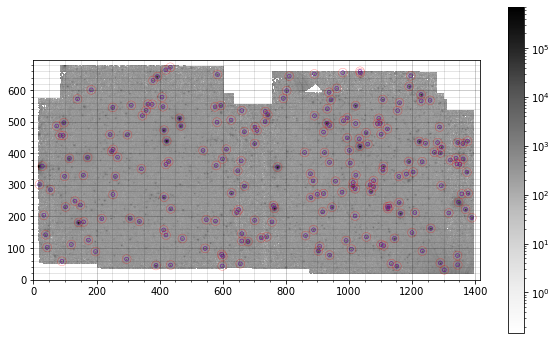

In [4]:
daofind = DAOStarFinder(threshold = 20. * std, fwhm = 3.)
sources = daofind(data - median)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.75)
annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_bigbig.png', dpi=500)

In [5]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1302.2448 30.489824      157632.94            nan
  2  1151.819 42.288902      218773.09      222422.43
  3 598.49265 42.883834      73395.914            nan
  4 388.30685 44.418565      509694.47            nan
  5 434.63538 45.923358      157754.15            nan
  6 1344.7003 46.585935      251993.95      343926.73
  7 655.52652 49.789563      113786.47            nan
  8 1134.4152 50.481568      107761.92      198436.34
  9  1289.763 52.564654       466308.8      364416.36
 10 90.162848 57.727084      74719.204            nan
...       ...       ...            ...            ...
209 392.97166 643.20011      1583912.9      317077.69
210 810.66268  644.6901       84794.33      203321.34
211 1195.8901 645.81866      77758.676      141537.92
212 583.32007 649.84535      254842.65      160617.02
213 890.32819 651.68884     

In [6]:
annulus_masks = annuli.to_mask(method='center')
aperture_correction = 1.125

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_annuli, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_annuli)
    
bkg_median = np.array(bkg_median)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = aperture_correction * (phot_table['aperture_sum_0'] - phot_table['aper_bkg'])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix    ...                                         
--- --------- --------- ... -------------- --------- ---------------
  1 1302.2448 30.489824 ...      894.32312 101145.56       63548.304
  2  1151.819 42.288902 ...      423.21561 47864.557        192272.1
  3 598.49265 42.883834 ...      323.80988 36622.034       41370.614
  4 388.30685 44.418565 ...      452.70729 51199.988       515806.29
  5 434.63538 45.923358 ...      369.78671 41821.892       130423.79
  6 1344.7003 46.585935 ...      673.77191 76201.808       197766.16
  7 655.52652 49.789563 ...      352.24197 39837.629        83192.45
  8 1134.4152 50.481568 ...      371.40367 42004.766       73976.795
  9  1289.763 52.564654 ...      701.58685 79347.604       435331.35
 10 90.162848 57.727084 ...      336.82147 38093.611       41203.792
...       ...       ... ...            ...       ...             ...
209 392.97166 643.20011 ...      5

In [27]:
cutout_size = 150    # this whole bit might not work properly, since the image doesn't go all the way to the edges of the graph
hsize = (cutout_size - 1) / 2
x = phot_table['xcenter'].value
y = phot_table['ycenter'].value
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_table = Table()
star_table['x'] = x[mask]
star_table['y'] = y[mask]

print(star_table)

        x                  y         
------------------ ------------------
 938.6967108110418  77.34898070134523
 596.7005837529861  79.47697439968066
196.59217828544058  88.54644400823882
    903.2838786101  90.52785472192144
1232.6450516470425  90.25284732141462
 1007.838492383995   96.0955419289503
 544.1617535219864  98.59129695378135
 907.1051444070914 105.09550970795168
 1110.003744508116 107.06966681844952
119.91833609506078 110.75484296621552
               ...                ...
 943.1344070324382  569.3874182606074
1107.1256271148802  570.3060528919561
139.73495012422222   572.190790643258
 792.1432909195038  574.1548943464418
407.35501211412077  578.0912589543142
1228.6173921013656  586.3259605468878
  936.859788605091  593.2961313565271
 802.6302285393386  598.4431035832293
183.06967553875035  601.1170846444622
 961.2712056371206  605.9232201779805
1190.8959571704468  612.0810676459344
Length = 175 rows


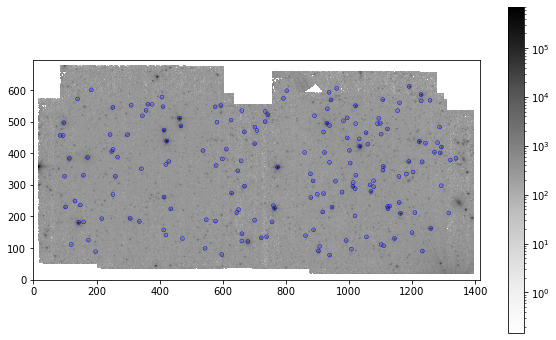

In [28]:
starpos = np.transpose((star_table['x'], star_table['y']))
starap = CircularAperture(starpos, r=6.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5)
plt.gcf().set_size_inches(10, 6)

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


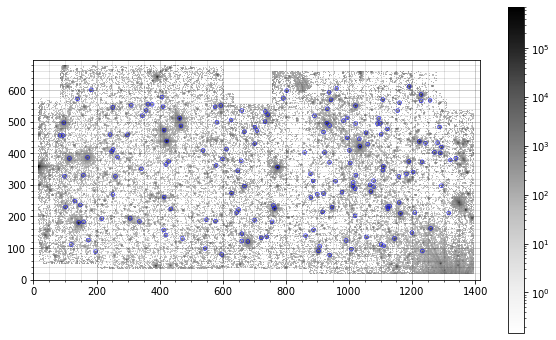

In [29]:
_, median_sub, _ = sigma_clipped_stats(data, sigma=4.)
data_sub = data - median_sub

plt.imshow(data_sub, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5, alpha=1.)
#annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_subdata.png', dpi=500)

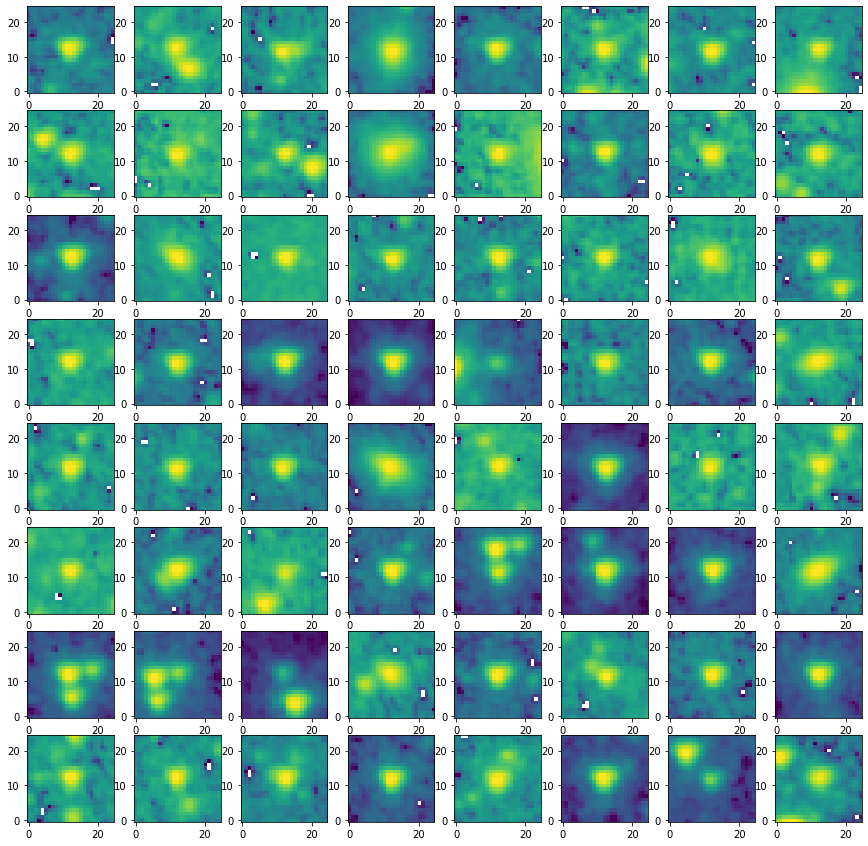

In [46]:
nddata = NDData(data = data_sub)
stars = extract_stars(nddata, star_table, size=25)
nrows = 8
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15), squeeze=True)
ax = ax.ravel()

for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

In [71]:
# maxiters = 3 looks good to me, oversampling could either be 3 or 4 (unless we want original resolution)
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

#print(fitted_stars.data)

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


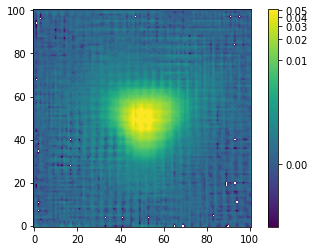

In [72]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()